In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from itertools import product


# Ładowanie i transformacja danych

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

transform = transforms.ToTensor()

train_data = torchvision.datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

def get_subset(dataset, percentage):
    subset_size = int(len(dataset) * percentage)
    return Subset(dataset, list(range(subset_size)))


Using device: cuda


# Definicja modelu

In [4]:
class SingleLayerNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SingleLayerNN, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

class TwoLayerNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TwoLayerNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        return self.fc2(x)


# Funkcja trenująca

In [5]:
def train_model(model, train_loader, test_loader, num_epochs, criterion, optimizer, device):
    model.to(device)
    train_losses, test_losses, accuracies = [], [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))

        model.eval()
        test_loss, correct = 0, 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                test_loss += criterion(outputs, targets).item()
                _, predicted = outputs.max(1)
                correct += (predicted == targets).sum().item()

        test_losses.append(test_loss / len(test_loader))
        accuracies.append(100 * correct / len(test_loader.dataset))
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracies[-1]:.2f}%")

    return train_losses, test_losses, accuracies


# Eksperymenty

In [6]:
input_size = 28 * 28
num_classes = 10
hidden_sizes = [64, 128, 256]
batch_sizes = [16, 32, 64]
percentages = [0.01, 0.1, 1.0]
num_epochs = 20

def train_with_params(batch_size, hidden_size, percentage):
    subset = get_subset(train_data, percentage)
    train_loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    model = TwoLayerNN(input_size, hidden_size, num_classes)
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    train_losses, test_losses, accuracies = train_model(model, train_loader, test_loader, num_epochs=num_epochs, criterion=criterion, optimizer=optimizer, device=device)
    return train_losses, test_losses, accuracies


# Wpływ batch size na wyniki

Running: 
	batch size: 16
	hidden size: 128
	percentage: 1.0
Epoch 1/20, Loss: 0.7436, Accuracy: 80.74%
Epoch 2/20, Loss: 0.4908, Accuracy: 82.28%
Epoch 3/20, Loss: 0.4483, Accuracy: 83.73%
Epoch 4/20, Loss: 0.4215, Accuracy: 84.49%
Epoch 5/20, Loss: 0.4021, Accuracy: 85.35%
Epoch 6/20, Loss: 0.3868, Accuracy: 85.36%
Epoch 7/20, Loss: 0.3735, Accuracy: 85.47%
Epoch 8/20, Loss: 0.3635, Accuracy: 85.74%
Epoch 9/20, Loss: 0.3539, Accuracy: 86.18%
Epoch 10/20, Loss: 0.3457, Accuracy: 86.10%
Epoch 11/20, Loss: 0.3370, Accuracy: 86.52%
Epoch 12/20, Loss: 0.3304, Accuracy: 87.08%
Epoch 13/20, Loss: 0.3232, Accuracy: 85.70%
Epoch 14/20, Loss: 0.3171, Accuracy: 85.86%
Epoch 15/20, Loss: 0.3114, Accuracy: 86.86%
Epoch 16/20, Loss: 0.3060, Accuracy: 87.30%
Epoch 17/20, Loss: 0.3001, Accuracy: 87.38%
Epoch 18/20, Loss: 0.2958, Accuracy: 87.54%
Epoch 19/20, Loss: 0.2904, Accuracy: 87.36%
Epoch 20/20, Loss: 0.2867, Accuracy: 87.83%
Time taken for batch size 16: 121.32 seconds
Running: 
	batch size: 

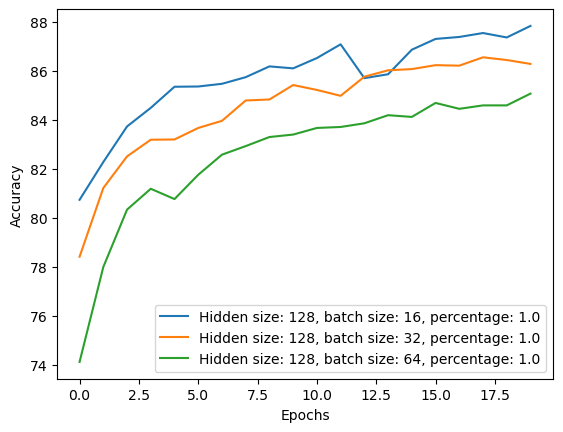

In [7]:
import time

percentage = 1.0
hidden_size = 128

for batch_size in batch_sizes:
    print(f"Running: \n\tbatch size: {batch_size}\n\thidden size: {hidden_size}\n\tpercentage: {percentage}")
    start_time = time.time()
    train_losses, test_losses, accuracies = train_with_params(batch_size, hidden_size, percentage)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Time taken for batch size {batch_size}: {elapsed_time:.2f} seconds")
    plt.plot(accuracies, label=f'Hidden size: {hidden_size}, batch size: {batch_size}, percentage: {percentage}')

plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

## Wpływ batch size na wyniki - Wnioski
Jak można było przewidzieć, im mniejszy batch size, tym lepsze wyniki, kosztem czasu działania.  
Jeżeli bardzo zależy na czasie, batch size 32 kosztem 10 dodatkowych sekund daje dużo lepsze wyniki niż 64.  
Jednak batch size 16 daje jeszcze zauważalnie lepszy wynik od 32

# Wpływ wielkości warstwy ukrytej na wyniki

Running: 
	batch size: 16
	hidden size: 64
	percentage: 1.0
Epoch 1/20, Loss: 0.7450, Accuracy: 81.15%
Epoch 2/20, Loss: 0.4926, Accuracy: 81.54%
Epoch 3/20, Loss: 0.4519, Accuracy: 83.29%
Epoch 4/20, Loss: 0.4273, Accuracy: 82.59%
Epoch 5/20, Loss: 0.4082, Accuracy: 84.59%
Epoch 6/20, Loss: 0.3935, Accuracy: 84.73%
Epoch 7/20, Loss: 0.3816, Accuracy: 85.59%
Epoch 8/20, Loss: 0.3706, Accuracy: 85.66%
Epoch 9/20, Loss: 0.3615, Accuracy: 85.68%
Epoch 10/20, Loss: 0.3533, Accuracy: 85.38%
Epoch 11/20, Loss: 0.3450, Accuracy: 85.98%
Epoch 12/20, Loss: 0.3388, Accuracy: 85.98%
Epoch 13/20, Loss: 0.3306, Accuracy: 86.34%
Epoch 14/20, Loss: 0.3250, Accuracy: 86.60%
Epoch 15/20, Loss: 0.3195, Accuracy: 86.91%
Epoch 16/20, Loss: 0.3133, Accuracy: 86.61%
Epoch 17/20, Loss: 0.3083, Accuracy: 87.01%
Epoch 18/20, Loss: 0.3038, Accuracy: 86.86%
Epoch 19/20, Loss: 0.2990, Accuracy: 86.54%
Epoch 20/20, Loss: 0.2953, Accuracy: 87.31%
Running: 
	batch size: 16
	hidden size: 128
	percentage: 1.0
Epoch 1/

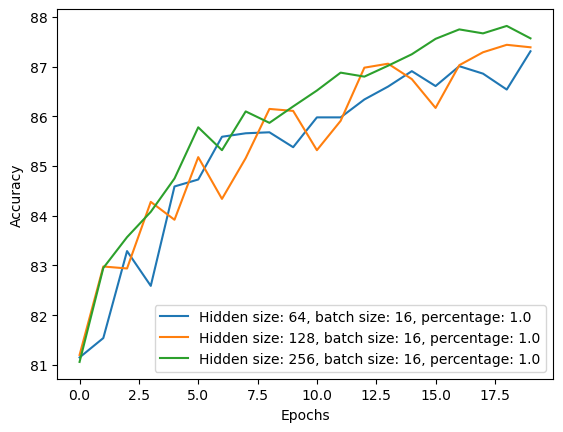

In [8]:
percentage = 1.0
batch_size = 16

for hidden_size in hidden_sizes:
    print(f"Running: \n\tbatch size: {batch_size}\n\thidden size: {hidden_size}\n\tpercentage: {percentage}")
    train_losses, test_losses, accuracies = train_with_params(batch_size, hidden_size, percentage)
    plt.plot(accuracies, label=f'Hidden size: {hidden_size}, batch size: {batch_size}, percentage: {percentage}')


plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

## Wpływ wielkości warstwy ukrytej na wyniki - Wnioski
Wielkość warstwy ukrytej nie ma aż tak dużego wpływu na wyniki jak batch size.  
Można zauważyć, że wielkości 64 i 128 dają bardzo podobne wyniki.  
Jednak wielkość 256 prawie w całym procesie uczenia daje najwyższe accuracy, i ma bardziej jednostajny wzrost wraz z kolejnymi epokami, podczas gdy mniejsze wielkości mają spore wahania.

# Wpływ ilości danych na wyniki

Running: 
	batch size: 16
	hidden size: 128
	percentage: 0.01
Epoch 1/20, Loss: 2.2253, Accuracy: 38.26%
Epoch 2/20, Loss: 2.0576, Accuracy: 49.00%
Epoch 3/20, Loss: 1.8794, Accuracy: 53.42%
Epoch 4/20, Loss: 1.6956, Accuracy: 53.89%
Epoch 5/20, Loss: 1.5283, Accuracy: 55.25%
Epoch 6/20, Loss: 1.3918, Accuracy: 62.35%
Epoch 7/20, Loss: 1.2694, Accuracy: 62.81%
Epoch 8/20, Loss: 1.1901, Accuracy: 61.64%
Epoch 9/20, Loss: 1.1251, Accuracy: 63.90%
Epoch 10/20, Loss: 1.0582, Accuracy: 62.91%
Epoch 11/20, Loss: 1.0109, Accuracy: 64.17%
Epoch 12/20, Loss: 0.9652, Accuracy: 66.43%
Epoch 13/20, Loss: 0.9203, Accuracy: 66.96%
Epoch 14/20, Loss: 0.9008, Accuracy: 67.29%
Epoch 15/20, Loss: 0.8725, Accuracy: 66.91%
Epoch 16/20, Loss: 0.8499, Accuracy: 67.86%
Epoch 17/20, Loss: 0.8296, Accuracy: 66.59%
Epoch 18/20, Loss: 0.8031, Accuracy: 69.63%
Epoch 19/20, Loss: 0.7797, Accuracy: 70.09%
Epoch 20/20, Loss: 0.7666, Accuracy: 71.06%
Running: 
	batch size: 16
	hidden size: 128
	percentage: 0.1
Epoch 

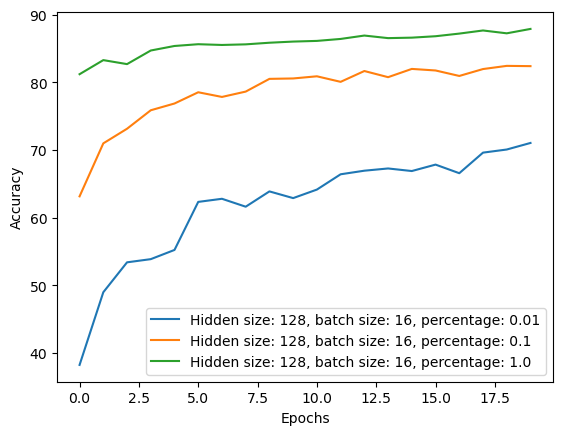

In [9]:
batch_size = 16
hidden_size = 128

for percentage in percentages:
    print(f"Running: \n\tbatch size: {batch_size}\n\thidden size: {hidden_size}\n\tpercentage: {percentage}")
    train_losses, test_losses, accuracies = train_with_params(batch_size, hidden_size, percentage)
    plt.plot(accuracies, label=f'Hidden size: {hidden_size}, batch size: {batch_size}, percentage: {percentage}')

plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

## Wpływ ilości danych na wyniki - Wnioski
Większa ilość danych daje bez wątpienia lepsze wyniki, szczególnie przy mniejszej ilości epok.  
Przy wzroście liczby epok różnica dalej jest duża, ale maleje w stosunku do początkowych epok.  

In [1]:
def train_with_params_1layer(batch_size, hidden_size, percentage):
    subset = get_subset(train_data, percentage)
    train_loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    model = TwoLayerNN(input_size, hidden_size, num_classes)
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    train_losses, test_losses, accuracies = train_model(model, train_loader, test_loader, num_epochs=num_epochs, criterion=criterion, optimizer=optimizer, device=device)
    return train_losses, test_losses, accuracies
